In [2]:
# Launch GUI
# uv run evc-gui -c easyvolcap/configs/exps/envgs/ref_real/envgs_sedan.yaml

In [ ]:
# The trained gaussians are stored inside the .pt file and contain:
# m['model'].keys()
# odict_keys([
#   'sampler.bg_color',                # shape: [3]
#   'sampler.env_bg_color',            # shape: [3]
#
#   'sampler.pcd.active_sh_degree',    # shape: [1] 
#   'sampler.pcd._xyz',                # shape: [N, 3]
#   'sampler.pcd._features_dc',        # shape: [N, 1, 3]
#   'sampler.pcd._features_rest',      # shape: [N, 15, 3]
#   'sampler.pcd._scaling',            # shape: [N, 2]
#   'sampler.pcd._rotation',           # shape: [N, 4]
#   'sampler.pcd._opacity',            # shape: [N, 1]
#   'sampler.pcd._specular',           # shape: [N, 1]  # Used to blend rt reflections with rasterized gaussians, is trained in the ray tracing phase
#   'sampler.pcd._roughness',          # shape: [N, 1]  # Not used for rendering, is trained in the ray tracing phase
#   'sampler.pcd.max_radii2D',         # shape: [N]
#   'sampler.pcd.xyz_gradient_accum',  # shape: [N, 1]
#   'sampler.pcd.denom',               # shape: [N, 1]
#   'sampler.pcd.xyz_weight_accum',    # shape: [N, 1]
#
#   'sampler.env.active_sh_degree', 
#   'sampler.env._xyz', 
#   'sampler.env._features_dc', 
#   'sampler.env._features_rest', 
#   'sampler.env._scaling', 
#   'sampler.env._rotation', 
#   'sampler.env._opacity', 
#   'sampler.env._specular', 
#   'sampler.env._roughness', 
#   'sampler.env.max_radii2D', 
#   'sampler.env.xyz_gradient_accum', 
#   'sampler.env.denom', 
#   'sampler.env.xyz_weight_accum'])
# divided into 'pcd' and 'env' parts, pcd meaning Point Cloud Data
# for the sedan scene N for pcd is 1 800 000, N for env is 507 497
#
# The optix tracing takes 6x longer as splat rasterization:
# 78.5 ms per frame for the hw.render_gaussians() call from HardwareRendering().cuda()
# 13 ms per frame for the render() call from gaussian2d_utils

In [1]:
# Copied from easyvolcap/easyvolcap/utils/gaussian2d_utils.py
import numpy as np
import math
import torch
from easyvolcap.utils.base_utils import dotdict

def fov2focal(fov, pixels):
    return pixels / (2 * np.tan(fov / 2))


def focal2fov(focal, pixels):
    return 2 * np.arctan(pixels / (2 * focal))


@torch.jit.script
def getWorld2View(R: torch.Tensor, t: torch.Tensor):
    """
    R: ..., 3, 3
    T: ..., 3, 1
    """
    sh = R.shape[:-2]
    T = torch.eye(4, dtype=R.dtype, device=R.device)  # 4, 4
    for i in range(len(sh)):
        T = T.unsqueeze(0)
    T = T.expand(sh + (4, 4))
    T[..., :3, :3] = R
    T[..., :3, 3:] = t
    return T


@torch.jit.script
def getProjectionMatrix(fovx: torch.Tensor, fovy: torch.Tensor, znear: torch.Tensor, zfar: torch.Tensor):
    tanfovy = math.tan((fovy / 2))
    tanfovx = math.tan((fovx / 2))

    t = tanfovy * znear
    b = -t
    r = tanfovx * znear
    l = -r

    P = torch.zeros(4, 4, dtype=znear.dtype, device=znear.device)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (r - l)
    P[1, 1] = 2.0 * znear / (t - b)

    P[0, 2] = (r + l) / (r - l)
    P[1, 2] = (t + b) / (t - b)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)

    P[2, 3] = -(zfar * znear) / (zfar - znear)

    return P


def make_camera_batch(H, W, K, R, T, n=0.1, f=100.0):
    # Input camera params should be on CPU
    output = dotdict()

    output.image_height = H
    output.image_width = W

    fl_x = K[0, 0]  # use cpu K
    fl_y = K[1, 1]  # use cpu K
    FoVx = focal2fov(fl_x, W)
    FoVy = focal2fov(fl_y, H)

    output.K = K.cuda()
    output.R = R.cuda()
    output.T = T.cuda()
    n = torch.tensor(n)
    f = torch.tensor(f)

    # if 'msk' in batch: output.gt_alpha_mask = batch.msk[0]  # FIXME: whatever for now

    output.world_view_transform = getWorld2View(R, T).transpose(0, 1).cuda()
    output.projection_matrix = getProjectionMatrix(FoVx, FoVy, n, f).transpose(0, 1).cuda()
    output.full_proj_transform = torch.matmul(output.world_view_transform, output.projection_matrix).cuda()
    output.camera_center = (-R.mT @ T)[..., 0].cuda()  # B, 3, 1 -> 3,

    # Set up rasterization configuration
    output.FoVx = FoVx.cuda()
    output.FoVy = FoVy.cuda()
    output.tanfovx = math.tan(FoVx * 0.5)
    output.tanfovy = math.tan(FoVy * 0.5)

    output.znear = n.cuda()
    output.zfar = f.cuda()

    return output


In [2]:
import torch
from easyvolcap.utils.gaussian2d_utils import GaussianModel

def load_splats(ckpt_path):
    state = torch.load(ckpt_path, map_location="cpu")["model"]
    
    # Dummy GaussianModel
    pcd = GaussianModel(
            xyz=torch.empty(1, 3, device="cuda"),
            colors=None,
            sh_degree=3,
            render_reflection=True,
            specular_channels=True,
            xyz_lr_scheduler=None,  # key fix: avoid lr_init/lr_final access
        )

    # Dummy GaussianModel
    env = GaussianModel(
            xyz=torch.empty(1, 3, device="cuda"),
            colors=None,
            sh_degree=3,
            render_reflection=False,
            specular_channels=True,
            xyz_lr_scheduler=None,  # key fix: avoid lr_init/lr_final access
        )

    # Separate parameters of pcd and env based on prefix. NOTE: Pretty smelly code
    loaded_params_pcd = {k[len("sampler.pcd."):]: v for k, v in state.items() if k.startswith("sampler.pcd.")}
    loaded_params_env = {k[len("sampler.env."):]: v for k, v in state.items() if k.startswith("sampler.env.")}

    pcd.load_state_dict(loaded_params_pcd, strict=False)
    env.load_state_dict(loaded_params_env, strict=False)

    return pcd.cuda(), env.cuda()


In [3]:
from easyvolcap.utils.gaussian2d_utils import render
from easyvolcap.utils.optix_utils import HardwareRendering
from easyvolcap.utils.ray_utils import get_rays

torch.set_grad_enabled(False)

# Copied from easyvolcap/easyvolcap/utils/math_utils.py
@torch.jit.script
def normalize(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    # channel last: normalization
    return x / (torch.norm(x, dim=-1, keepdim=True) + eps)


def render_frame(pcd, env, cam):
    # Diffuse pass (rasterizer) for pcd gaussians
    pipe_dif = dotdict(convert_SHs_python=True, compute_cov3D_python=False, depth_ratio=0.0)
    bg = torch.zeros(3, device="cuda")
    dif = render(cam, pcd, pipe_dif, bg)
    dif_rgb = dif.render.permute(1, 2, 0)
    norm_map = dif.rend_normal.permute(1, 2, 0)
    dpt_map = dif.surf_depth.permute(1, 2, 0)
    spec_map = dif.specular.permute(1, 2, 0)

    # Calculate ray directions per pixel
    w,h = cam.image_width.item(), cam.image_height.item()
    ray_o, ray_d = get_rays(h, w, cam.K, cam.R, cam.T, correct_pix=True, z_depth=True)

    # Calculate reflected rays in screen space
    norm = normalize(norm_map)
    ref_d = ray_d - 2 * (ray_d * norm).sum(-1, keepdim=True) * norm
    ref_o = ray_o + ray_d * dpt_map

    # Trace reflected rays through the env gaussians using OptiX
    hw = HardwareRendering().cuda()
    pipe_env = dotdict(convert_SHs_python=False, compute_cov3D_python=False, depth_ratio=0.0)
    env_bg = torch.zeros(3, device="cuda")
    env_out = hw.render_gaussians(
        cam, ref_o, ref_d, env, pipe_env, env_bg,
        max_trace_depth=0,
        specular_threshold=0.0,
        start_from_first=False,
        batch=cam,
    )
    env_rgb = env_out.render.permute(1, 2, 0)

    # Blend
    rgb = (1.0 - spec_map) * dif_rgb + spec_map * env_rgb
    rgb8 = (rgb.clamp(0, 1) * 255).to(torch.uint8).cpu().numpy()
    return rgb8

In [4]:
import matplotlib.pyplot as plt

In [5]:
pcd, env = load_splats("/home/roman/ba/envgs/data/trained_model/envgs_sedan/latest.pt")

12:45:28 [INIT] NUM POINTS: 1                            ]8;id=601502;file:///home/roman/ba/envgs/easyvolcap/easyvolcap/utils/gaussian2d_utils.py\gaussian2d_utils.py]8;;\:]8;id=766981;file:///home/roman/ba/envgs/easyvolcap/easyvolcap/utils/gaussian2d_utils.py#438\438]8;;\

         [INIT] NUM POINTS: 1                            ]8;id=770977;file:///home/roman/ba/envgs/easyvolcap/easyvolcap/utils/gaussian2d_utils.py\gaussian2d_utils.py]8;;\:]8;id=839955;file:///home/roman/ba/envgs/easyvolcap/easyvolcap/utils/gaussian2d_utils.py#438\438]8;;\

In [6]:
def aabb_intersect(xyz, minX, maxX, minY, maxY, minZ, maxZ):
    # AABB intersection
    mins = torch.tensor([minX, minY, minZ], device=xyz.device, dtype=xyz.dtype)
    maxs = torch.tensor([maxX, maxY, maxZ], device=xyz.device, dtype=xyz.dtype)

    mask = (xyz >= mins).all(dim=1) & (xyz <= maxs).all(dim=1)
    return mask


In [7]:
mask = aabb_intersect(pcd._xyz, -3,3,-3,3,-3,3)

In [8]:
pcd._xyz[mask].shape

torch.Size([223308, 3])

╭──────────────────────────────────────────────────────────────────────────────╮
│ pcd._xyz =   # shape: [N, 3]                                                 │
│              ▲                                                               │
╰──────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [10]:
# Dummy camera
H,W = 480, 640
fx = fy = 500.0
K = [[fx, 0.0, W * 0.5],
        [0.0, fy, H * 0.5],
        [0.0, 0.0, 1.0]]
R = [[1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]]
T = [[0.0], [0.0], [3.0]]
cam = make_camera_batch(torch.tensor(H),
                        torch.tensor(W), 
                        torch.tensor(K), 
                        torch.tensor(R), 
                        torch.tensor(T))

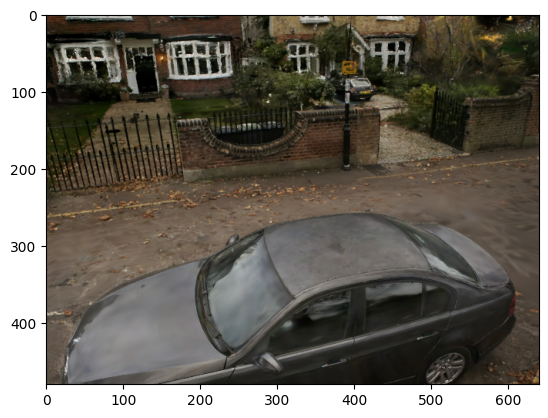

In [11]:
plt.imshow(render_frame(pcd, env, cam))

In [ ]:

import viser
import nerfview
import numpy as np

def get_render_inputs(W, H, c2w, K):
    Rc = c2w[:3, :3]
    tc = c2w[:3, 3]

    R = Rc.T
    T = (-R @ tc).reshape(3, 1)  # 3x1 (use .reshape(3,) if you need 3,)

    cam_dict = make_camera_batch(
        torch.tensor(H), 
        torch.tensor(W), 
        torch.tensor(K), 
        torch.tensor(R), 
        torch.tensor(T), 
    )
    return cam_dict

def render_fn(
    camera_state: nerfview.CameraState, render_tab_state: nerfview.RenderTabState
) -> np.ndarray:
    # Parse camera state for camera-to-world matrix (c2w) and intrinsic (K) as
    # float64 numpy arrays.
    if render_tab_state.preview_render:
        width = render_tab_state.render_width
        height = render_tab_state.render_height
    else:
        width = render_tab_state.viewer_width
        height = render_tab_state.viewer_height
    
    c2w = camera_state.c2w
    K = camera_state.get_K([width, height])

    cam = get_render_inputs(width, height, c2w, K)
    img = render_frame(pcd, env, cam)
    return img

# Initialize a viser server and our viewer.
server = viser.ViserServer(verbose=False)
viewer = nerfview.Viewer(server=server, render_fn=render_fn, mode='rendering')

╭────── viser (listening *:8080) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

: 

In [ ]:
#(H, W, K, R, T, n=0.1, f=100.0):